### Notebook to visualize stimuli that are perceptually similar across train and test splits. Borrows from:

Colab notebook: https://colab.research.google.com/drive/1taEOMzFE9g81D9AwH27Uhy2U82tQGAVI?usp=sharing#scrollTo=zYW_kw2Kv8sJ

GitHub Project Page: https://dreamsim-nights.github.io/

In [4]:
from dotenv import load_dotenv
load_dotenv()
from dreamsim import dreamsim
from PIL import Image
import torch
import os
import matplotlib.pyplot as plt
from dreamsim import PerceptualModel
from tqdm import tqdm
import torch.nn.functional as F
import pandas as pd
import pickle
import glob as glob


In [5]:
#helper functions
def show_imgs(ims, captions=None):
    fig, ax = plt.subplots(nrows=1, ncols=len(ims), figsize=(10, 5))
    for i in range(len(ims)):
        ax[i].imshow(ims[i])
        ax[i].axis('off')
        if captions is not None:
          ax[i].set_title(captions[i], fontweight="bold")
          
def get_embeddings(embeddings_root, model, name, preprocess, images, device):
  embeddings = []
  for img in tqdm(images):
    img = preprocess(img).to(device)
    embeddings.append(model.embed(img).detach().cpu())
  with open(os.path.join(embeddings_root, f"{name}_embeds.pkl"), "wb") as f:
    pickle.dump(embeddings, f)

def sorted_directory_listing_with_os_listdir(directory):
    items = os.listdir(directory)
    sorted_items = sorted(items)
    return sorted_items

def nearest_neighbors(embeddings_train, embeddings_query, query_index):
    query_embed = embeddings_query[query_index]
    dists = {}

    # Compute the (cosine) distance between the query embedding
    # and each search image embedding
    for i, im in enumerate(embeddings_train):
      dists[i] = (1 - F.cosine_similarity(query_embed, embeddings_train[i],
                                          dim=-1)).item()

    # Return results sorted by distance
    df = pd.DataFrame({"ids": list(dists.keys()), "dists": list(dists.values())})
    df = df.sort_values(by="dists")
    return df


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
tmp_dir="/data/vision/oliva/scratch/blahner" #put the dreamsim weights in a scratch directory
model, preprocess = dreamsim(pretrained=True, cache_dir=os.path.join(tmp_dir,".cache"))
bmd_dataset_root = "/data/vision/oliva/scratch/datasets/BOLDMomentsDataset"
cc2017_dataset_root = "/data/vision/oliva/scratch/datasets/CC2017"

Using device: cuda
Using cached /data/vision/oliva/scratch/blahner/.cache


Using cache found in /data/vision/oliva/scratch/blahner/.cache/facebookresearch_dino_main


In [7]:
dreamsim_model = model
dino_model = PerceptualModel(feat_type='cls', model_type='dino_vitb16', stride='16', baseline=True, device="cuda")
open_clip_model = PerceptualModel(feat_type='embedding', model_type='open_clip_vitb32', stride='32', baseline=True, device="cuda")

Using cache found in ./models/facebookresearch_dino_main


### Retrieve the top k nearest neighbor training stimuli to each testing stimuli in CC2017

In [8]:
embeddings_root = os.path.join(cc2017_dataset_root, "video_fmri_dataset", "stimuli_metadata", "clipped_2s", "dreamsim_embeddings")
if not os.path.exists(embeddings_root):
    os.makedirs(embeddings_root)

test_images = []
train_images = []
directory = os.path.join(cc2017_dataset_root, "video_fmri_dataset", "stimuli_metadata", "clipped_2s", "frames_middle")

sorted_filenames = sorted_directory_listing_with_os_listdir(directory)

for filename in sorted_filenames:
  full_path = os.path.join(directory, filename)
  if 'seg' in filename:
    train_images.append(Image.open(full_path))
  elif 'test' in filename:
    test_images.append(Image.open(full_path))
  else:
    print(f"failed to find image {full_path}")

KeyboardInterrupt: 

In [10]:
#compute embeddings for training frames
get_embeddings(embeddings_root, dreamsim_model, "dreamsim_train", preprocess, train_images, device)
get_embeddings(embeddings_root, dino_model, "dino_train", preprocess, train_images, device)
get_embeddings(embeddings_root, open_clip_model, "open_clip_train", preprocess, train_images, device)

#compute embeddings for testing frames
get_embeddings(embeddings_root, dreamsim_model, "dreamsim_test", preprocess, test_images, device)
get_embeddings(embeddings_root, dino_model, "dino_test", preprocess, test_images, device)
get_embeddings(embeddings_root, open_clip_model, "open_clip_test", preprocess, test_images, device)

100%|██████████| 1200/1200 [00:15<00:00, 76.78it/s]


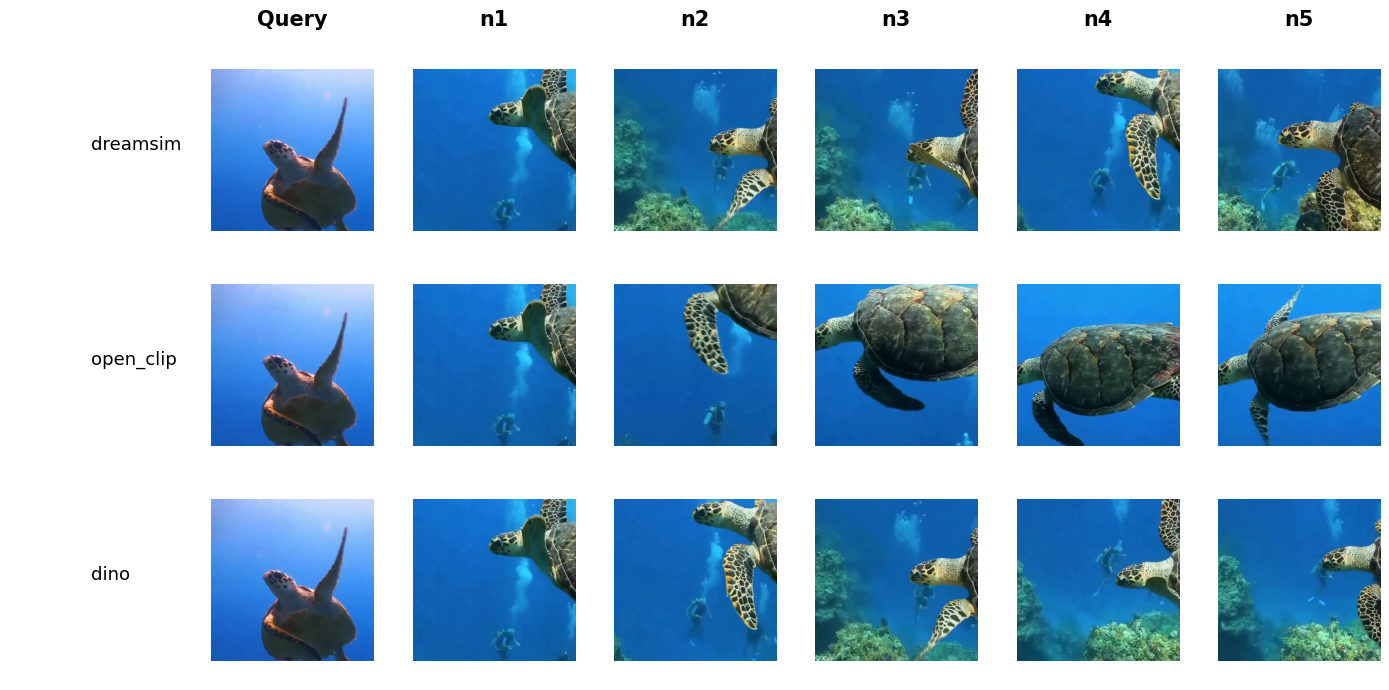

In [91]:
query_index = 107 #@param {type:"number"}
n = 5
display_width = 11
display_height = 4

## Load embeddings for each metric and compute nearest neighbors to the query_index-th image
nn_dfs = {}
for metric_name in ["dreamsim", "open_clip", "dino"]:
    with open(os.path.join(embeddings_root, f"{metric_name}_train_embeds.pkl"), "rb") as f:
        embeddings_train = pickle.load(f)
    with open(os.path.join(embeddings_root, f"{metric_name}_test_embeds.pkl"), "rb") as f:
        embeddings_test = pickle.load(f)
    
    nn_dfs[metric_name] = nearest_neighbors(embeddings_train, embeddings_test, query_index)

## Plot results
f, ax = plt.subplots(4, n+2, figsize=(14,7), gridspec_kw={"height_ratios":[0.005,1,1,1]})
ax[0,0].axis('off')
for col in range(1, n+2):
    title = "Query" if col == 1 else f"n{col-1}"
    ax[0, col].set_title(title, fontweight="bold", fontsize=15)
    ax[0, col].axis('off')

for i, name in enumerate(["dreamsim", "open_clip", "dino"]):
    ax[i+1, 0].text(0.5, 0.5, name, fontsize=13)
    ax[i+1, 0].axis('off')

    ax[i+1, 1].imshow(test_images[query_index])
    ax[i+1, 1].axis("off")

    for j in range(n):
        im_idx = nn_dfs[name]['ids'].iloc[j]
        ax[i + 1, j + 2].imshow(train_images[im_idx])
        ax[i + 1, j + 2].axis('off')
plt.tight_layout()

### Retrieve the top k nearest neighbor training stimuli to each testing stimuli in BMD

In [9]:
embeddings_root = os.path.join(bmd_dataset_root, "derivatives", "stimuli_metadata", "dreamsim_embeddings")
if not os.path.exists(embeddings_root):
    os.makedirs(embeddings_root)

test_images = []
train_images = []
directory = os.path.join(bmd_dataset_root, "derivatives","stimuli_metadata","frames_middle")

sorted_filenames = sorted_directory_listing_with_os_listdir(directory)

for filename in sorted_filenames:
  stimulus_idx = int(filename.split('_')[0])
  full_path = os.path.join(directory, filename)
  if stimulus_idx <= 1000:
    train_images.append(Image.open(full_path))
  elif (stimulus_idx <= 1102) and (stimulus_idx > 1000):
    test_images.append(Image.open(full_path))
  else:
    print(f"failed to find image {full_path}")

In [ ]:
#compute embeddings for training frames
get_embeddings(embeddings_root, dreamsim_model, "dreamsim_train", preprocess, train_images, device)
get_embeddings(embeddings_root, dino_model, "dino_train", preprocess, train_images, device)
get_embeddings(embeddings_root, open_clip_model, "open_clip_train", preprocess, train_images, device)

#compute embeddings for testing frames
get_embeddings(embeddings_root, dreamsim_model, "dreamsim_test", preprocess, test_images, device)
get_embeddings(embeddings_root, dino_model, "dino_test", preprocess, test_images, device)
get_embeddings(embeddings_root, open_clip_model, "open_clip_test", preprocess, test_images, device)

0.12059533596038818
0.41567832231521606
0.4174073338508606
0.422534704208374
0.42680585384368896


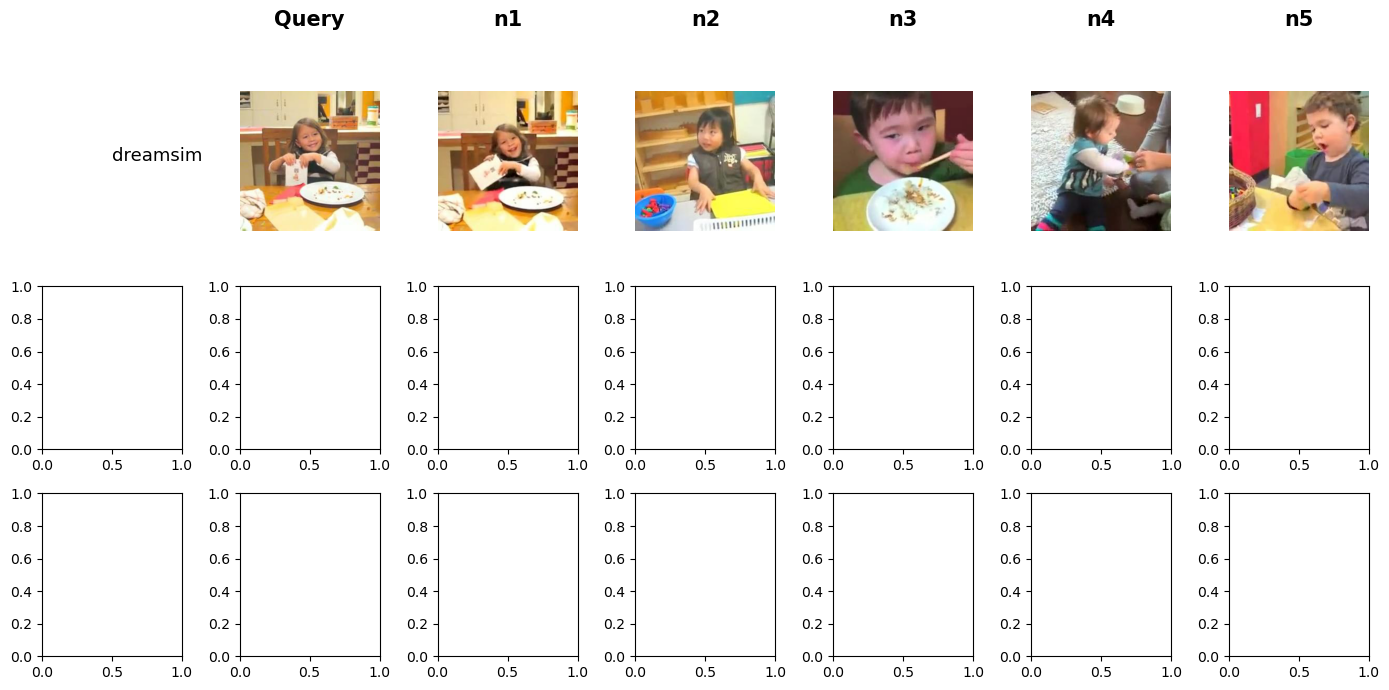

In [20]:
query_index = 26 #@param {type:"number"}
n = 5
display_width = 11
display_height = 4

## Load embeddings for each metric and compute nearest neighbors to the query_index-th image
nn_dfs = {}
for metric_name in ["dreamsim", "open_clip", "dino"]:
    with open(os.path.join(embeddings_root, f"{metric_name}_train_embeds.pkl"), "rb") as f:
        embeddings_train = pickle.load(f)
    with open(os.path.join(embeddings_root, f"{metric_name}_test_embeds.pkl"), "rb") as f:
        embeddings_test = pickle.load(f)
    
    nn_dfs[metric_name] = nearest_neighbors(embeddings_train, embeddings_test, query_index)

## Plot results
f, ax = plt.subplots(4, n+2, figsize=(14,7), gridspec_kw={"height_ratios":[0.005,1,1,1]})
ax[0,0].axis('off')
for col in range(1, n+2):
    title = "Query" if col == 1 else f"n{col-1}"
    ax[0, col].set_title(title, fontweight="bold", fontsize=15)
    ax[0, col].axis('off')

for i, name in enumerate(["dreamsim"]):  #["dreamsim", "open_clip", "dino"]):
    ax[i+1, 0].text(0.5, 0.5, name, fontsize=13)
    ax[i+1, 0].axis('off')

    ax[i+1, 1].imshow(test_images[query_index])
    ax[i+1, 1].axis("off")

    for j in range(n):
        im_idx = nn_dfs[name]['ids'].iloc[j]
        score = nn_dfs[name]['dists'].iloc[j]
        print(score)
        ax[i + 1, j + 2].imshow(train_images[im_idx])
        ax[i + 1, j + 2].axis('off')
plt.tight_layout()

In [15]:
nn_dfs['dreamsim']

,ids,dists
805,805,0.543537
632,632,0.600708
551,551,0.610767
462,462,0.610771
913,913,0.628916
...,...,...
776,776,0.924035
866,866,0.925099
702,702,0.929657
700,700,0.933330
